### Imports

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import ipywidgets as ipw
from numpy.random import randn, rand

#matplotlib.rcParams['figure.facecolor'] = 'white'
#import vector_valued_with_RFF

#from vector_valued_with_RFF import capital_psi, alpha_approx

### Simulation parameters

In [40]:
w_0 = 0.1*2*np.pi
zeta = 1/np.sqrt(2)
# np.zeroes_like - return array of zeros w. same shape and type as a given array

time_start = 0
time_end = 100
time_step = 0.05 # this gives 2000 steps

time_series = np.arange(time_start, time_end, time_step)
number_of_timesteps = len(time_series)
init_condition = np.array([2, -2])

size_of_state = 2

### Van der Pol Oscillator

In [41]:
epsilon = 2

def model_van_der_pol(t, x):
    list = [x[1], epsilon * (1 - x[0]**2) * x[1] - x[0]]
    return np.array(list)

In [42]:
"""# Solve diff. equations with ODE
# similar to ODE45 in python: results = solve_ivp(obj_func, t_span, y0, t_eval = time_series)

# noise for a bit of challange
noise_sigma = 0.0

# init data containers
x = np.zeros((size_of_state, number_of_timesteps))
y = np.zeros((size_of_state, number_of_timesteps))

x[:, 0] = init_condition.T + np.multiply(noise_sigma, np.array(randn(size_of_state)))
y[:, 0] = model_van_der_pol(time_start, init_condition)

for i in range(0, number_of_timesteps - 1):
    timespan = [time_series[i], time_series[i + 1]]
    start_state = x[:, i]

    # Sample dynamics at current time step
    y[:, i] = model_van_der_pol(time_series[i], start_state)
    
    # Propogate the state trajectory to next the time step using ODE-solver
    # solve_ivp is to replace the ode45 - solving odes
    partial_trajectory = solve_ivp(model_van_der_pol, timespan, start_state).y
    
    x[:, i+1] = partial_trajectory[:, -1] + np.multiply(noise_sigma, np.array(randn(size_of_state)))"""

'# Solve diff. equations with ODE\n# similar to ODE45 in python: results = solve_ivp(obj_func, t_span, y0, t_eval = time_series)\n\n# noise for a bit of challange\nnoise_sigma = 0.0\n\n# init data containers\nx = np.zeros((size_of_state, number_of_timesteps))\ny = np.zeros((size_of_state, number_of_timesteps))\n\nx[:, 0] = init_condition.T + np.multiply(noise_sigma, np.array(randn(size_of_state)))\ny[:, 0] = model_van_der_pol(time_start, init_condition)\n\nfor i in range(0, number_of_timesteps - 1):\n    timespan = [time_series[i], time_series[i + 1]]\n    start_state = x[:, i]\n\n    # Sample dynamics at current time step\n    y[:, i] = model_van_der_pol(time_series[i], start_state)\n    \n    # Propogate the state trajectory to next the time step using ODE-solver\n    # solve_ivp is to replace the ode45 - solving odes\n    partial_trajectory = solve_ivp(model_van_der_pol, timespan, start_state).y\n    \n    x[:, i+1] = partial_trajectory[:, -1] + np.multiply(noise_sigma, np.array(ran

### Harmonic Oscillator

In [43]:
def harmonic_oscillator(t, x):
    """Free Harmonic Oscillator ODE (Ordinary Differential equation)"""
    list = [x[1], -x[0]]
    return np.array(list)

In [44]:
"""#Comment ut when running Harmonic
# Solve diff. equations with ODE
# similar to ODE45 in python: results = solve_ivp(obj_func, t_span, y0, t_eval = time_series)

# noise for a bit of challange
noise_sigma = 0.0

# init data containers
x = np.zeros((size_of_state, number_of_timesteps))
y = np.zeros((size_of_state, number_of_timesteps))

x[:, 0] = init_condition.T + np.multiply(noise_sigma, np.array(randn(size_of_state)))
y[:, 0] = harmonic_oscillator(time_start, init_condition)

for i in range(0, number_of_timesteps - 1):
    timespan = [time_series[i], time_series[i + 1]]
    start_state = x[:, i]

    # Sample dynamics at current time step
    y[:, i] = harmonic_oscillator(time_series[i], start_state)
    
    # Propogate the state trajectory to next the time step using ODE-solver
    # solve_ivp is to replace the ode45 - solving odes
    partial_trajectory = solve_ivp(harmonic_oscillator, timespan, start_state).y

    x[:, i+1] = partial_trajectory[:, -1] + np.multiply(noise_sigma, np.array(randn(size_of_state)))"""

'#Comment ut when running Harmonic\n# Solve diff. equations with ODE\n# similar to ODE45 in python: results = solve_ivp(obj_func, t_span, y0, t_eval = time_series)\n\n# noise for a bit of challange\nnoise_sigma = 0.0\n\n# init data containers\nx = np.zeros((size_of_state, number_of_timesteps))\ny = np.zeros((size_of_state, number_of_timesteps))\n\nx[:, 0] = init_condition.T + np.multiply(noise_sigma, np.array(randn(size_of_state)))\ny[:, 0] = harmonic_oscillator(time_start, init_condition)\n\nfor i in range(0, number_of_timesteps - 1):\n    timespan = [time_series[i], time_series[i + 1]]\n    start_state = x[:, i]\n\n    # Sample dynamics at current time step\n    y[:, i] = harmonic_oscillator(time_series[i], start_state)\n    \n    # Propogate the state trajectory to next the time step using ODE-solver\n    # solve_ivp is to replace the ode45 - solving odes\n    partial_trajectory = solve_ivp(harmonic_oscillator, timespan, start_state).y\n\n    x[:, i+1] = partial_trajectory[:, -1] + 

### Damped Harmonic Oscillator

In [45]:
def damped_harmonic_oscillator(t, x):
    zeta = 0.7
    w0 = 2*(np.pi)
    list = [x[1], -w0*(w0*x[0] + 2*zeta*x[1])]
    return np.array(list)

y = damped_harmonic_oscillator(0, [2, -2])
print(y)

[ -2.         -61.36391635]


In [46]:
#Comment out when running damped harmonic
# Damped: 
# Solve diff. equations with ODE
# noise
noise_sigma = 0.0

# init data containers
x = np.zeros((size_of_state, number_of_timesteps))
y = np.zeros((size_of_state, number_of_timesteps))

x[:, 0] = init_condition + np.multiply(noise_sigma, np.array(randn(size_of_state)))
y[:, 0] = damped_harmonic_oscillator(time_start, init_condition)

for i in range(0, number_of_timesteps - 1):
    timespan = [time_series[i], time_series[i + 1]]
    start_state = x[:, i]

    # Sample dynamics at current time step
    y[:, i] = damped_harmonic_oscillator(time_series[i], start_state)

    # Propogate the state trajectory to next the time step using ODE-solver
    # solve_ivp is to replace the ode45 - solving odes
    partial_trajectory = solve_ivp(damped_harmonic_oscillator, timespan, start_state).y

    x[:, i+1] = partial_trajectory[:, -1] + np.multiply(noise_sigma, np.array(randn(size_of_state)))


print(y)

[[-2.00000000e+000 -4.35689084e+000 -5.53001849e+000 ... -2.61779056e-190
  -1.80109832e-190  0.00000000e+000]
 [-6.13639163e+001 -3.41337390e+001 -1.38900124e+001 ...  1.77271410e-189
   1.48809413e-189  0.00000000e+000]]


### Generate data for vector field and streamlines

In [47]:
"""
# For Van der Pol 
lower_bound_x1 = -3
upper_bound_x1 = 3
lower_bound_x2 = -4
upper_bound_x2 = 4

# For Harmonic
lower_bound_x1 = -3
upper_bound_x1 = 3
lower_bound_x2 = -3
upper_bound_x2 = 3
"""
#For Damped Harmonic
lower_bound_x1 = -3
upper_bound_x1 = 3
lower_bound_x2 = -6
upper_bound_x2 = 6

num_of_points = 11

x1 = np.linspace(lower_bound_x1, upper_bound_x1, num_of_points)
x2 = np.linspace(lower_bound_x2, upper_bound_x2, num_of_points)

# Base point or starting points for each vector of the vector field
[X1, X2] = np.meshgrid(x1, x2)

# Calculate df/dt for each point
t = 0

u = np.zeros(X1.shape)
v = np.zeros(X1.shape)
u_norm = np.zeros(X1.shape)
v_norm = np.zeros(X1.shape)

for (i,j), value in np.ndenumerate(X1):
    # get velocities at each point
    #Y_prime = model_van_der_pol(t, np.array([value, X2[i, j]])) # Van der Pol
    #Y_prime = harmonic_oscillator(t, np.array([value, X2[i, j]])) # Harmonic
    Y_prime = damped_harmonic_oscillator(t, np.array([value, X2[i, j]])) # Damped Harmonic
    u[i,j] = Y_prime[0]
    v[i,j] = Y_prime[1]

    # normalize vector length
    V_mod = np.sqrt(u[i,j]**2 + v[i,j]**2)
    u_norm[i,j] = u[i,j] / V_mod
    v_norm[i,j] = v[i,j] / V_mod

C:\Users\vilde\AppData\Local\Temp\ipykernel_15680\3374945445.py:46: RuntimeWarning: invalid value encountered in double_scalars
  u_norm[i,j] = u[i,j] / V_mod
C:\Users\vilde\AppData\Local\Temp\ipykernel_15680\3374945445.py:47: RuntimeWarning: invalid value encountered in double_scalars
  v_norm[i,j] = v[i,j] / V_mod


### Plot Van der Pol model

[[-6.  -6.  -6.  -6.  -6.  -6.  -6.  -6.  -6.  -6.  -6. ]
 [-4.8 -4.8 -4.8 -4.8 -4.8 -4.8 -4.8 -4.8 -4.8 -4.8 -4.8]
 [-3.6 -3.6 -3.6 -3.6 -3.6 -3.6 -3.6 -3.6 -3.6 -3.6 -3.6]
 [-2.4 -2.4 -2.4 -2.4 -2.4 -2.4 -2.4 -2.4 -2.4 -2.4 -2.4]
 [-1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2]
 [ 2.4  2.4  2.4  2.4  2.4  2.4  2.4  2.4  2.4  2.4  2.4]
 [ 3.6  3.6  3.6  3.6  3.6  3.6  3.6  3.6  3.6  3.6  3.6]
 [ 4.8  4.8  4.8  4.8  4.8  4.8  4.8  4.8  4.8  4.8  4.8]
 [ 6.   6.   6.   6.   6.   6.   6.   6.   6.   6.   6. ]]


Text(0, 0.5, 'x2')

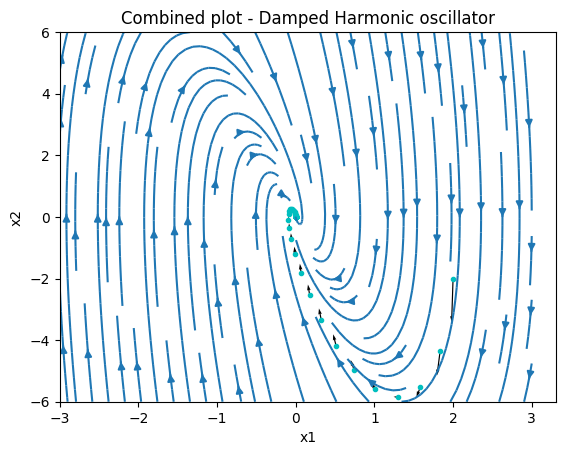

In [48]:
# Plot resulting trajectory in the data set and belonging streamlines
# Combine solution and vector field
plt.figure()
plt.style.use('default')
#plt.title('Combined plot - Van der Pol oscillator')
#plt.title('Combined plot - Harmonic oscillator')
plt.title('Combined plot - Damped Harmonic oscillator')
plt.plot(x[0,:],x[1,:], '.', linewidth=1, color='c')

print(u)

#ff.create_streamline(X1, X2, u, v)
plt.streamplot(X1, X2, u, v, density = 1)
plt.quiver(x[0,:], x[1,:], y[0,:], y[1,:], scale = 700)
plt.xlabel('x1')
plt.ylabel('x2')

### Regression problem

In [49]:
# Extract data series for y in the regression problem
data_series_start = np.argwhere(time_series == 15)[0,0] # to take the first element
data_series_end = np.argwhere(time_series == 22.6)[0,0]

# Training data

#x_train = x[:, :]
#y_train = y[:, :]
#x_train = x[:,  data_series_start:data_series_end]
#y_train = y[:,  data_series_start:data_series_end]

# init data containers
x_train = np.zeros((size_of_state, number_of_timesteps))
y_train = np.zeros((size_of_state, number_of_timesteps))

x_train[:, 0] = init_condition + np.multiply(noise_sigma, np.array(randn(size_of_state)))
#y_train[:, 0] = model_van_der_pol(time_start, init_condition)
y_train[:, 0] = damped_harmonic_oscillator(time_start, init_condition)


#x_train = x[:,  data_series_start:data_series_end+1]
#y_train = y[:,  data_series_start:data_series_end+1]

num_of_points = x_train.shape[1]
dim_of_function = y_train.shape[0]

for i in range(0, num_of_points-1):
    timespan = [time_series[i], time_series[i + 1]]
    start_state = x_train[:, i]

    # Sample dynamics at current time step
    #y_train[:, i] = model_van_der_pol(time_series[i], start_state) #Van der Pol
    #y_train[:, i] = harmonic_oscillator(time_series[i], start_state) # Harmonic
    y_train[:, i] = damped_harmonic_oscillator(time_series[i], start_state) # Damped Harmonic

    
    # Propogate the state trajectory to next the time step using ODE-solver
    # solve_ivp is to replace the ode45 - solving odes
    # partial_trajectory = solve_ivp(model_van_der_pol, timespan, start_state).y
    # partial_trajectory = solve_ivp(harmonic_oscillator, timespan, start_state).y # Harmonic

    partial_trajectory = solve_ivp(damped_harmonic_oscillator, timespan, start_state).y # Damped Harmonic
    x_train[:, i+1] = partial_trajectory[:, -1] + np.multiply(noise_sigma, np.array(randn(size_of_state)))
# Query only the length of the second dimension of x_train
num_of_points = x_train.shape[1]
dim_of_function = y_train.shape[0]


#### Plot resulting trajectory in the data set and belonging streamlines

(-6.0, 6.0)

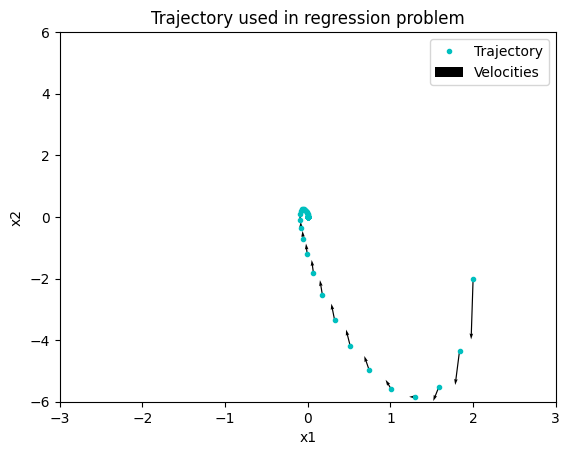

In [50]:
plt.style.use('default')
plt.figure()
plt.title('Trajectory used in regression problem')
plt.plot(x_train[0,:], x_train[1,:],'.', linewidth=2, color='c')
plt.quiver(x_train[0,:],x_train[1,:],y_train[0,:],y_train[1,:], scale = 500)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(['Trajectory', 'Velocities'])
plt.xlim([lower_bound_x1, upper_bound_x1])
plt.ylim([lower_bound_x2, upper_bound_x2])

### Regression

In [51]:
# Random Fourier Features
sigma = 5
#num_of_samples = 10
num_of_samples = 20

w = randn(size_of_state, num_of_samples)/sigma

#w = np.array([[0.137335660755815,	-0.0964647451986580,	-0.257950231619626,	-0.235136044790995,	0.216548743000084,	-0.0892186836721056,	0.0576902528467201,	-0.252356649715657,	0.0100067749958766,	-0.00942130989703832],
#[-0.0394847015681784,	0.0402960614334587,	-0.0438394794523012,	-0.106718601697240,	0.0462584259092475,	0.0782377948816800,	-0.0813293682874597,	0.358906071236453,	0.329342089459239,	0.247243386448447]])
b = rand(1,num_of_samples)*2*np.pi
#b = np.array([4.97450669326908,	3.10562748276755,	0.0859033716740748,	1.50931577514904,	2.75128760574900,	5.57933203925003,	5.73792644569505,	3.91854738070030,	2.94814981741237,	5.17829056864708])
#b = b.reshape((1, num_of_samples))

### RFF

In [52]:
def psi(x, w, b):
    return np.sqrt(2) * np.cos(w.T@x + b)

def psi_vector(x, w, b, m):
    psi_vector = np.zeros(m)
    for i in range(m):
        x = x.reshape((-1,))
        psi_vector[i] = psi(x, w[:, i], b[:,i])
    return np.array(psi_vector)

def capital_psi(x, w, b, m, dim):
    psi = psi_vector(x, w, b, m)
    return np.kron(psi, np.eye(dim))

def phi(x, w, b, n, m, dim):
    phi = np.zeros((dim*n, dim*m))
    for i in range(0, n):
        psi = capital_psi(x[:,i], w, b, m, dim)
        phi[dim*i] = psi[0]
        phi[dim*i+1] = psi[1]
    return phi

def alpha_approx(x_vector, y, dim, m, lam, n):
    phi_ = phi(x_vector, w, b, n, m, dim)
    alpha_inv_part = np.linalg.inv(phi_.T @ phi_ + lam*np.eye(dim*m))
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F')) # Viktig!
    alpha = alpha_inv_part @ (phi_.T @ y_reshaped)
    return alpha

In [53]:
#x_train = x[:, data_series_start:data_series_end+1]
#y_train = y[:, data_series_start:data_series_end+1]
x_train = x[:, 0:1000]
y_train = y[:, 0:1000]
num_of_points = x_train.shape[1]
dim_of_function = y_train.shape[0]

# Get alphas (coefficient vectors)
lambda_ = 0.000001 # regularization parameter lamda
alpha_array_rff = alpha_approx(x_train, y_train, dim_of_function, num_of_samples, lambda_, num_of_points)
phi_ = phi(x_train, w, b, num_of_points, num_of_samples, dim_of_function)

In [54]:
def learnt_model(t, x):
    func = capital_psi(x, w, b, num_of_samples, dim_of_function) @ alpha_array_rff
    return func

In [55]:
learnt_model2 = lambda t, x : np.transpose(capital_psi(x, w, b, num_of_samples, dim_of_function) @ alpha_array_rff)

### Simulation paramters

In [56]:
init_time = 0
end_time = 45
timespan = np.array([init_time, end_time])
init_condition = np.array(([2, -2]))
t = np.linspace(init_time, end_time, 500)

# Solve diff. equations using learnt model with solve_ivp
#data_series = solve_ivp(learnt_model, timespan, init_condition).y
data_series = solve_ivp(learnt_model, timespan, init_condition, t_eval = t).y
print(data_series.shape)

(2, 500)


### Plot simulated trajectory and streamslices for learnt model


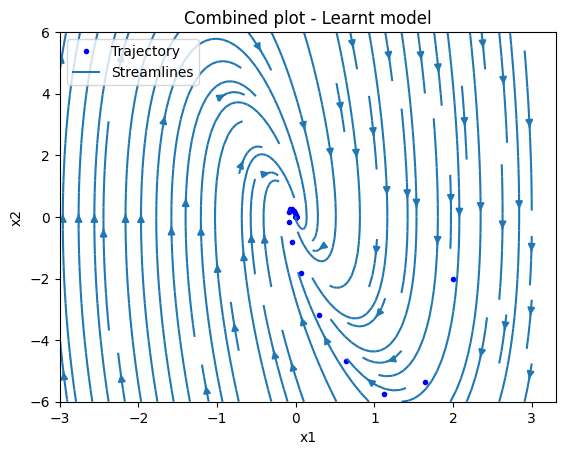

In [57]:
u_learnt = np.zeros(X1.shape)
v_learnt = np.zeros(X1.shape)

# Create callable function for learnt dynamics (straight from working note)

# for loop to get the velocity at each point witht the learnt model
for (i,j), value in np.ndenumerate(X1):
    # get velocities at each point
    Y_prime = learnt_model(t, np.array([value, X2[i, j]]))
    u_learnt[i,j] = Y_prime[0]
    v_learnt[i,j] = Y_prime[1]

plt.figure()
plt.title('Combined plot - Learnt model')
plt.plot(data_series[0, :], data_series[1, :], '.', linewidth=1, color="b")
plt.streamplot(X1, X2, u_learnt, v_learnt)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(['Trajectory', 'Streamlines'])
#plt.xlim([lower_bound_x1, upper_bound_x1])
#plt.ylim([lower_bound_x2, upper_bound_x2])